# LSTM : génération de mélodies

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importations

In [2]:
import sys
import os
import json
import matplotlib.pyplot as plt

In [3]:
sys.path.append('/content/drive/MyDrive/')
sys.path.append('/content/drive/MyDrive/data')
sys.path.append('/content/drive/MyDrive/LSTM')

In [4]:
from extract_data import *
from melodypreprocessor import *
from melodygenerator import *
from LSTM import *
from train import *
from visualization import *

## Extraction des données des fichiers xml

In [5]:
'''#Extractions des partitions a partir des fichiers xml
path_to_xml = "/content/drive/MyDrive/data/data_xml"
file_output = "/content/drive/MyDrive/data/data.json"

D = data_to_json(path_to_xml)
with open(file_output, 'w',encoding="utf-8") as f:
    json.dump(D,f,indent=2)
print(f'{file_output} with {len(D)} scores created.')'''

'#Extractions des partitions a partir des fichiers xml\npath_to_xml = "/content/drive/MyDrive/data/data_xml"\nfile_output = "/content/drive/MyDrive/data/data.json"\n\nD = data_to_json(path_to_xml)\nwith open(file_output, \'w\',encoding="utf-8") as f:\n    json.dump(D,f,indent=2)\nprint(f\'{file_output} with {len(D)} scores created.\')'

## Extraction des mélodies

In [6]:
'''#Extraction des melodies par partie
filename = "/content/drive/MyDrive/data/dataset"
size_melody = 3 #en mesure ( 1000 = max de la partie )
time_signatures = set(["2/4"]) #prend toutes les time signatures par default

parts_len = json_into_part_melody("/content/drive/MyDrive/data/data.json",output_file=filename,size=size_melody,time_signatures=time_signatures)
print("Toutes les melodies ont étés générées par parties. Tailles des parties : "+" ".join([f"{key} : {length} " for key,length in parts_len]))'''

'#Extraction des melodies par partie\nfilename = "/content/drive/MyDrive/data/dataset"\nsize_melody = 3 #en mesure ( 1000 = max de la partie )\ntime_signatures = set(["2/4"]) #prend toutes les time signatures par default\n\nparts_len = json_into_part_melody("/content/drive/MyDrive/data/data.json",output_file=filename,size=size_melody,time_signatures=time_signatures)\nprint("Toutes les melodies ont étés générées par parties. Tailles des parties : "+" ".join([f"{key} : {length} " for key,length in parts_len]))'

## Création du modèle

In [7]:
melody_preprocessor = MelodyPreprocessor("/content/drive/MyDrive/data/datasetA.json", batch_size=32)
train_dataset = melody_preprocessor.create_training_dataset()
vocab_size = melody_preprocessor.number_of_tokens_with_padding
max_length_melody = melody_preprocessor.max_melody_length

print("Taille du vocabulaire :",vocab_size)
print("Taille de la plus grande mélodie :",max_length_melody)

Taille du vocabulaire : 240
Taille de la plus grande mélodie : 40


In [8]:
embedding_dim = 64
model = LSTMModel(vocab_size,embedding_dim,max_length_melody)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Entraînement du modèle

In [9]:
epochs = 10
iters,losses = train(train_dataset,model,epochs)

Training the model ...


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch 8 Batch 509 Loss 0.8021361231803894
Epoch 8 Batch 510 Loss 0.832956850528717
Epoch 8 Batch 511 Loss 0.6222781538963318
Epoch 8 Batch 512 Loss 0.6214836835861206
Epoch 8 Batch 513 Loss 0.8532198071479797
Epoch 8 Batch 514 Loss 0.9459738731384277
Epoch 8 Batch 515 Loss 0.8853269219398499
Epoch 8 Batch 516 Loss 0.8142860531806946
Epoch 8 Batch 517 Loss 0.7688195705413818
Epoch 8 Batch 518 Loss 0.6720528602600098
Epoch 8 Batch 519 Loss 0.862971842288971
Epoch 8 Batch 520 Loss 0.7724295258522034
Epoch 8 Batch 521 Loss 0.8167001008987427
Epoch 8 Batch 522 Loss 0.9732071161270142
Epoch 8 Batch 523 Loss 1.0593316555023193
Epoch 8 Batch 524 Loss 0.7723240256309509
Epoch 8 Batch 525 Loss 0.9280394315719604
Epoch 8 Batch 526 Loss 0.8387690186500549
Epoch 8 Batch 527 Loss 0.9271333813667297
Epoch 8 Batch 528 Loss 1.0191587209701538
Epoch 8 Batch 529 Loss 0.8811152577400208
Epoch 8 Batch 530 Loss 0.8798248767852783


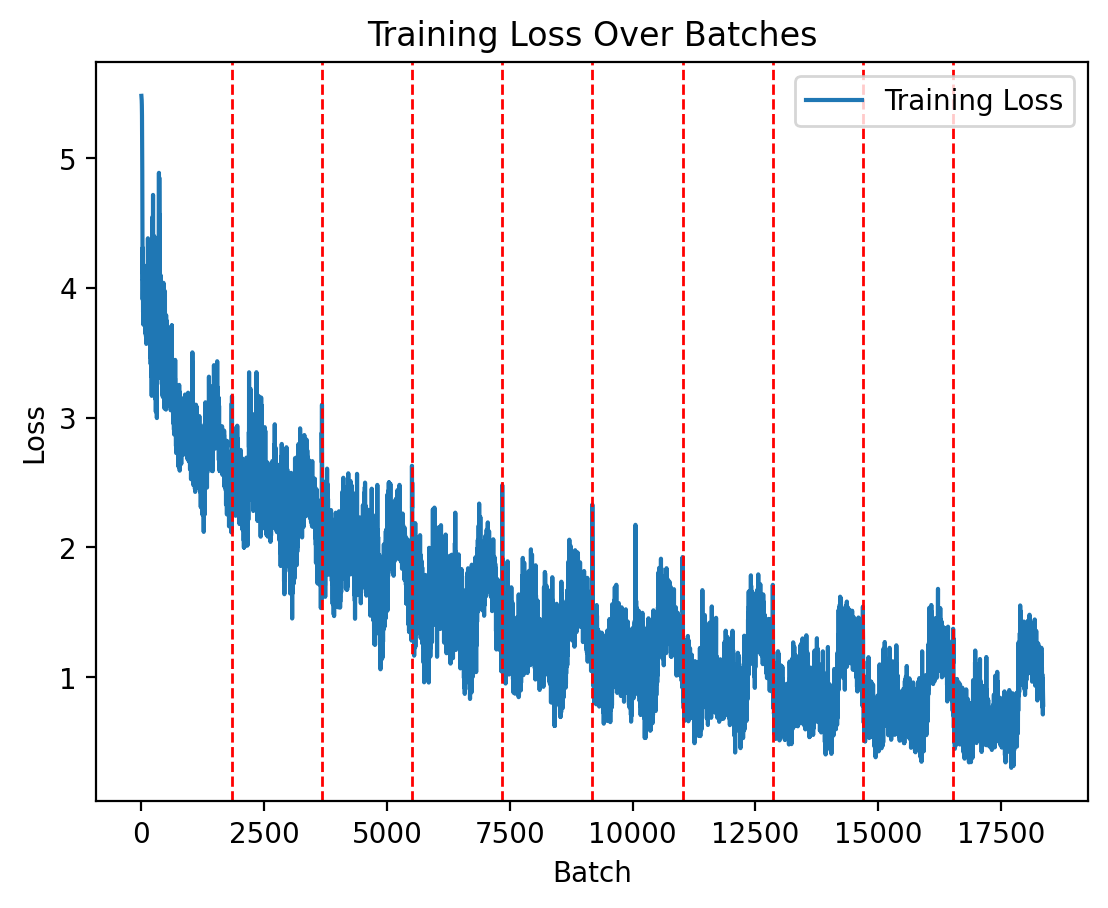

In [10]:
def plot_losses(iters,losses,batchs):
    plt.plot(iters,losses, label='Training Loss')
    for i in range(batchs,len(iters),batchs):
        plt.axvline(x=i, color='r', linestyle='--', linewidth=1)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Batches')
    plt.legend()
    plt.show()

plot_losses(iters,losses,1836)

## Génération

#### Paramètres

In [70]:
melodie_size = 3
lg_debut = 2 #Nombre de mesures pour la sequence initiale
lg_predict = 1 #Nombre de mesures pour la sequence prédite
nb_melodies = 10
max_notes = 20+8*lg_predict

MODE_DECALAGE = False #On prend lg_debut mesure de l'original pour prédire lg_predict et on decale

mode = 2 #0 highest prob   #2 categorical + temperature + topk sampling
forcing = 0.2  #entre 0 et 1, pourcentage de chance d'utiler les notes extraites de l'originale lors de la prédiction
top_k = 20

melody_generator = MelodyGenerator(
    model, melody_preprocessor.tokenizer,max_notes
)

In [71]:
error_part_A = ['Sarau para Radamés','DESPREZADO','ACARICIANDO','Dino Pintando o Sete Cordas','Ja Te Digo','CHORANDO']
melodies_generated = []

for _ in range(nb_melodies):
  print("Generating a melody...")
  seq = extract_random_seq("/content/drive/MyDrive/data/data.json",1,"A")
  print(f'Titre de l_original : {seq[0]}')
  original = extract_seq_from("/content/drive/MyDrive/data/data.json",seq[0],seq[2],mode="mesure")[-1]

  #Tant que la partie extraite ne correspond pas a la time signature ou quelle contient des mesures vides ( a fix)
  while seq[1]!= "2/4" or (seq[0] in error_part_A and MODE_DECALAGE):
      seq = extract_random_seq("/content/drive/MyDrive/data/data.json",1,"A")
      original = extract_seq_from("/content/drive/MyDrive/data/data.json",seq[0],seq[2],mode="mesure")[-1]

  if MODE_DECALAGE:
      new_melody,p = generate_decalage(melody_generator,original,2,1,k=top_k,first_proba=0.8)
      p = [prob for proba in p for prob in proba][:len(new_melody)]
      original = [n for m in original for n in m]
  else:
      debut = original[:lg_debut]
      debut = [n for m in debut for n in m]
      print(f'Sequence de départ : {debut}')
      original=[ n for m in original for n in m]
      #new_melody
      new_melody,p = melody_generator.generate(debut,forcing=forcing,melody=original,mode=mode,k=top_k,first_proba=0.6)
      new_melody = new_melody.split(' ')
      new_melody = n_measure(new_melody,lg_predict+lg_debut,"2/4")
      melody_lenght= len(new_melody)
      #proba
      p = [1]*len(debut)+p
      p = p[:melody_lenght]
  melodies_generated.append((seq,new_melody,original,p))
  print(new_melody)
  print(len(new_melody))
  print(len(p),p)

  print('---------------------')

print('Génération terminée')

Generating a melody...
Titre de l_original : 13 de Dezembro
Sequence de départ : ['C5-0.5', 'A4-0.25', 'C5-0.25', 'A4-0.5', 'G4-0.25', 'A4-0.25', 'F#4-0.5', 'E4-0.25', 'F#4-0.25', 'E4-0.5', 'D4-0.25', 'E4-0.25']
['C5-0.5', 'A4-0.25', 'C5-0.25', 'A4-0.5', 'G4-0.25', 'A4-0.25', 'F#4-0.5', 'E4-0.25', 'F#4-0.25', 'E4-0.5', 'D4-0.25', 'E4-0.25', 'rest-0.25', 'D4-0.25', 'G4-0.5', 'rest-1.0']
16
16 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.047133636, 0.048283372, 0.04664576, 0.04760297]
---------------------
Generating a melody...
Titre de l_original : TECLAS PRETAS
Sequence de départ : ['G4-0.25', 'A4-0.25', 'B4-0.25', 'D5-0.25', 'E5-0.25', 'G5-0.25', 'F#5-0.25', 'E5-0.25', 'D5-0.25', 'B4-0.25', 'A4-0.25', 'G4-0.25', 'F#4-0.25', 'E4-0.25', 'E-4-0.25', 'D4-0.25']
['G4-0.25', 'A4-0.25', 'B4-0.25', 'D5-0.25', 'E5-0.25', 'G5-0.25', 'F#5-0.25', 'E5-0.25', 'D5-0.25', 'B4-0.25', 'A4-0.25', 'G4-0.25', 'F#4-0.25', 'E4-0.25', 'E-4-0.25', 'D4-0.25', 'F#5-0.25', 'F#5-0.25', 'A5-0.5', 'F#5-0.25', 'F#5-0.5',

#### Enregistrement

In [72]:
generated = [ {'Title' : s[0] , "Time_signature" : s[1], 'Part': s[2], 'Key' : s[3] ,'Generated' : m , 'Original' : o , 'Proba' : [] if mode ==0 else [ str(prob) for prob in p ]} for (s,m,o,p) in melodies_generated ]

In [73]:
file_output = 'melody3_' if MODE_DECALAGE else ''
file_output += f'mode{mode}'
file_output += f'_top{top_k}' if mode==2 else ''
file_output += f'_forcing{forcing}' if forcing>0 else ''
print(file_output)

with open(f'/content/drive/MyDrive/Generated/{file_output}.json',"w") as f:
    json.dump(generated,f,indent=2)

mode2_top20_forcing0.2


## Visualisation

In [74]:
import music21
from music21 import *

#### Toutes les mélodies générées

In [77]:
show_all_generated(f"Generated/{file_output}.json").show("musicxml")

The file 'Generated/mode2_top20_forcing0.2.json' does not exist. Exiting program.


AttributeError: 'NoneType' object has no attribute 'show'

#### Comparaison de la mélodie i avec son original

In [78]:
num_melodie = 1
score = compare_generated(num_melodie, file_name=f"Generated/LSTM/{file_output}.json")
score.show("musicxml")

The file 'Generated/LSTM/mode2_top20_forcing0.2.json' does not exist. Exiting program.


AttributeError: 'NoneType' object has no attribute 'show'